import

In [224]:
import torch

from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn

データと中身

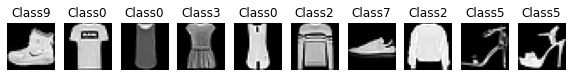

In [73]:
D = 28*28 # データの次元数
K = 10    # クラス数

# 学習データのインスタンス
dsL = FashionMNIST(root='data', train=True, transform = ToTensor(), download = True)
dlL = DataLoader(dsL, batch_size=100, shuffle=True) # バッチ数100 シャッフル
# テストデータのインスタンス
dsT = FashionMNIST(root='data', train=False, transform = ToTensor(), download = True)
dlT = DataLoader(dsT, batch_size=100, shuffle=True)

# 最初の10個のデータを表示
fig = plt.figure(figsize=(10, 2))
for n in range(10):
    x, y = dsL[n]  # n 番目の学習データ
    fig.add_subplot(1, 10, n+1)
    plt.title(f'Class{y}')
    plt.axis('off')
    plt.imshow(x.squeeze(), cmap='gray')
plt.show()

# 0	T-shirt/top
# 1	Trouser
# 2	Pullover
# 3	Dress
# 4	Coat
# 5	Sandal
# 6	Shirt
# 7	Sneaker
# 8	Bag
# 9	Ankle boot

ニューラルネットワークモデルの定義

In [74]:
class Logistic(nn.Module):

    #    D: 入力の大きさ（データの次元数）  K: 出力の大きさ（クラス数）
    def __init__(self, D, K):

        super(Logistic, self).__init__() # 初期化

        # インスタンス変数
        self.D = D
        self.K = K

        # 全結合層の定義 
        self.fc = nn.Linear(D, K) # 線形変換 input:D, output:K

        self.logsoftmax = nn.LogSoftmax(dim=1) # ソフトマックス関数

    # 出力を計算する
    def forward(self, X): # 順伝搬関数

        X = self.fc(X)
        X = self.logsoftmax(X)
        return X

学習

In [281]:
data = [] # グラフ描画用
model = Logistic(D, K).to('cpu') # cpu上で実行
# 交差エントロピー
loss_func = nn.NLLLoss(reduction='sum')

# SGD
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# 学習を関数として定義(引数にエポック数)
def gakusyu(nepoch):
    for t in range(nepoch):

        loss_sum = 0.0
        n = 0

        for X, lab in dlL:

            # X を (batchsize, 784)にする
            X = X.reshape((-1, D))

            Y = model(X)           # 一つのバッチ X を入力して出力 Y を計算
            loss = loss_func(Y, lab) # 正解ラベル Zt に対する loss を計算

            optimizer.zero_grad()  # 勾配をリセット
            loss.backward()        # 誤差逆伝播でパラメータ更新量を計算
            optimizer.step()       # パラメータを更新

            n += len(X)
            loss_sum += loss.item()  # 損失関数の値

        data.append(loss_sum/n)
        # print(t, loss_sum/n)

    plt.plot(range(len(data)), data)
    plt.xlabel("Epochs {}".format(len(data)))
    plt.ylabel("loss")
    plt.title("eta=0.001")
    plt.show()

交差エントロピーの変化

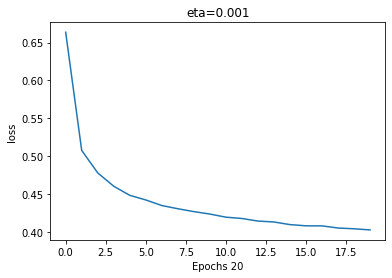

In [282]:
gakusyu(20)

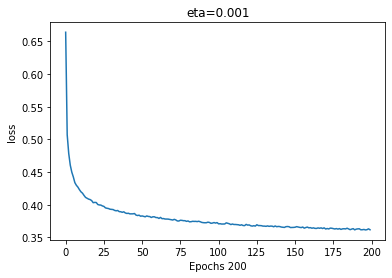

In [268]:
gakusyu(200)

In [283]:
model.eval() # モード切り替え

Logistic(
  (fc): Linear(in_features=784, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

## 20エポックでの結果

In [286]:
# 学習データ 6万
loss_sum = 0.0
ncorrect = 0
n = 0
data = []

for X, lab in dlL:

    # X を (batchsize, 1, 28, 28) から (batchsize, 784) へ reshape
    X = X.reshape((-1, D))

    Y = model(X)           # 一つのバッチ X を入力して出力 Y を計算
    loss = loss_func(Y, lab) # 正解ラベル Zt に対する loss を計算

    n += len(X)
    loss_sum += loss.item()  # 損失関数の値
    ncorrect += (Y.argmax(dim=1) == lab).sum().item()  # 正解数
    data.append(lab[Y.argmax(dim=1) != lab])

print(f'# L: {loss_sum/n:.4f} {ncorrect/n:.4f}')


# L: 0.4007 0.8620


In [275]:
def miss(missdata):
    # 間違えた個数を表示 (class:count percent)
    outdata = np.empty(0)
    for i in missdata:
        # print(i.numpy())
        outdata = np.hstack([outdata,i.numpy()])
        
    for k in range(10):
        print('{}:{} {:.2f}%'.format(k,(outdata == k).sum(),(outdata == k).mean()*100))

In [287]:
# 間違えた一部の例
print(lab[Y.argmax(dim=1) != lab]) # 正解ラベル
print(Y[Y.argmax(dim=1) != lab].argmax(dim=1)) # 間違えたラベル

miss(data)

tensor([6, 0, 5, 4, 4, 3, 2, 0])
tensor([0, 6, 9, 2, 2, 0, 4, 6])
0:882 10.65%
1:220 2.66%
2:921 11.12%
3:949 11.46%
4:1557 18.80%
5:406 4.90%
6:2391 28.87%
7:357 4.31%
8:303 3.66%
9:295 3.56%


In [288]:
# テストデータ　1万
loss_sum = 0.0
ncorrect = 0
n = 0
data = []
for X, lab in dlT:

    # X を (batchsize, 1, 28, 28) から (batchsize, 784) へ reshape
    X = X.reshape((-1, D))

    Y = model(X)           # 一つのバッチ X を入力して出力 Y を計算
    loss = loss_func(Y, lab) # 正解ラベル Zt に対する loss を計算

    n += len(X)
    loss_sum += loss.item()  # 損失関数の値
    ncorrect += (Y.argmax(dim=1) == lab).sum().item()  # 正解数
    data.append(lab[Y.argmax(dim=1) != lab])
# torch.stack(data,dim=0)
print(f'# T: {loss_sum/n:.4f} {ncorrect/n:.4f}')

# T: 0.4528 0.8395


In [289]:
# 間違えた一部の例
print(lab[Y.argmax(dim=1) != lab]) # 正解ラベル
print(Y[Y.argmax(dim=1) != lab].argmax(dim=1)) # 間違えたラベル

miss(data)

tensor([0, 6, 1, 7, 5, 0, 4, 2, 6, 5, 6, 6, 6, 6, 4, 2, 6, 6, 2, 4, 6])
tensor([6, 4, 6, 9, 9, 8, 6, 8, 2, 7, 2, 0, 0, 2, 6, 0, 0, 0, 1, 2, 2])
0:172 10.72%
1:45 2.80%
2:187 11.65%
3:183 11.40%
4:299 18.63%
5:87 5.42%
6:456 28.41%
7:60 3.74%
8:60 3.74%
9:56 3.49%


## 200エポックでの結果

In [274]:
# 学習データ 6万
loss_sum = 0.0
ncorrect = 0
n = 0
data = []

for X, lab in dlL:

    # X を (batchsize, 1, 28, 28) から (batchsize, 784) へ reshape
    X = X.reshape((-1, D))

    Y = model(X)           # 一つのバッチ X を入力して出力 Y を計算
    loss = loss_func(Y, lab) # 正解ラベル Zt に対する loss を計算

    n += len(X)
    loss_sum += loss.item()  # 損失関数の値
    ncorrect += (Y.argmax(dim=1) == lab).sum().item()  # 正解数
    data.append(lab[Y.argmax(dim=1) != lab])

print(f'# L: {loss_sum/n:.4f} {ncorrect/n:.4f}')

# L: 0.3553 0.8761


クラスを間違えた数

In [276]:
# 間違えた一部の例
print(lab[Y.argmax(dim=1) != lab]) # 正解ラベル
print(Y[Y.argmax(dim=1) != lab].argmax(dim=1)) # 間違えたラベル

miss(data)

tensor([0, 6, 7, 0, 3, 3, 2, 0, 2, 6, 0, 7, 6, 6])
tensor([6, 0, 9, 6, 4, 4, 6, 2, 4, 2, 6, 5, 2, 0])
0:1015 13.65%
1:159 2.14%
2:999 13.44%
3:642 8.64%
4:1255 16.88%
5:245 3.30%
6:2289 30.79%
7:379 5.10%
8:252 3.39%
9:199 2.68%


In [277]:
# テストデータ　1万
loss_sum = 0.0
ncorrect = 0
n = 0
data = []
for X, lab in dlT:

    # X を (batchsize, 1, 28, 28) から (batchsize, 784) へ reshape
    X = X.reshape((-1, D))

    Y = model(X)           # 一つのバッチ X を入力して出力 Y を計算
    loss = loss_func(Y, lab) # 正解ラベル Zt に対する loss を計算

    n += len(X)
    loss_sum += loss.item()  # 損失関数の値
    ncorrect += (Y.argmax(dim=1) == lab).sum().item()  # 正解数
    data.append(lab[Y.argmax(dim=1) != lab])
# torch.stack(data,dim=0)
print(f'# T: {loss_sum/n:.4f} {ncorrect/n:.4f}')

# T: 0.4493 0.8413


In [278]:
# 間違えた一部の例
print(lab[Y.argmax(dim=1) != lab]) # 正解ラベル
print(Y[Y.argmax(dim=1) != lab].argmax(dim=1)) # 間違えたラベル

miss(data)


tensor([0, 6, 1, 7, 5, 0, 4, 2, 6, 5, 6, 6, 6, 6, 4, 2, 6, 6, 2, 4, 6, 8])
tensor([6, 4, 6, 9, 9, 8, 6, 8, 2, 7, 2, 0, 0, 2, 6, 0, 0, 0, 1, 2, 0, 6])
0:212 13.36%
1:44 2.77%
2:210 13.23%
3:138 8.70%
4:270 17.01%
5:75 4.73%
6:457 28.80%
7:67 4.22%
8:69 4.35%
9:45 2.84%


# 結果と考察
手書き数字の際より識別率は低く、難易度が高い。  
今回行った200エポックまではエポック数を増やすにつれ、交差エントロピーは減少した。ただし減少率は鈍化していくため回数を増やしても以降も劇的な変化は見込めない。  
200エポックの学習でかかった時間は20エポックの10倍近かった。学習データの識別率の向上は1.4%、テストデータの識別率の向上は0.18%であったため過学習気味に思える。  
### 20エポックでの結果について
クラスを誤って判断した数を見ると、6:Shirtが最も多く、次に4クラス、そして0,2,3クラスが同程度で後に続く。最も誤った数が少なかったのは1:Trouserだった。誤って判断したデータの一部を見ると6は0:T-shirt/topと間違えやすいように見える。  
実際にサンプルの画像を見てみると6:Shirtと0:T-shirt/topの違いは前開きであるかの違いだった。そのため6と0の間違いが多いのだといえる。誤判断の割合が多かった0,2,3,4,6クラスは上半身の形に沿うもので、形状が似ているためこのような結果になったのだと考えた。反対に誤判断が少なかった1のTrouserはズボンで、他に似た形状のものは無かった。二本に分かれた形状は独特のため判断がつき易いのだろうか。
### 200エポックでの結果について
20エポックから改善した点をみると、3クラスを誤って判断する割合が減った。0,2,4,6クラスはトップスであり、3:Dressのみ唯一下半身を含む形であったため改善したのだと考えた。  

## メモ

In [81]:
class NeuralNetwork(nn.Module):
    def __init__(self, D, K):
        super(NeuralNetwork, self).__init__()
        self.D = D
        self.K = K
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(D, 512),
            nn.ReLU(), # 活性化関数
            nn.Linear(512, K),
        )

        # softmax（のlog）の定義
        self.logsoftmax = nn.LogSoftmax(dim=1) # ソフトマックス関数

    def forward(self, X):

        X = self.linear_relu_stack(X)
        X = self.logsoftmax(X)
        return X


In [82]:
model2 = NeuralNetwork(D, K).to('cpu')
print(model2)

eta = 0.001 # 学習率
# 交差エントロピー
loss_func2 = nn.NLLLoss(reduction='sum')

# SGD
optimizer2 = torch.optim.SGD(model2.parameters(), lr=eta)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
  (logsoftmax): LogSoftmax(dim=1)
)


In [83]:
nepoch = 10

for t in range(nepoch):

    loss_sum = 0.0
    n = 0

    for i, (X, lab) in enumerate(dlL):

        # X を (batchsize, 1, 28, 28) から (batchsize, 784) へ reshape
        X = X.reshape((-1, D))

        Y = model2(X)           # 一つのバッチ X を入力して出力 Y を計算
        loss = loss_func2(Y, lab) # 正解ラベル Zt に対する loss を計算

        optimizer2.zero_grad()  # 勾配をリセット
        loss.backward()        # 誤差逆伝播でパラメータ更新量を計算
        optimizer2.step()       # パラメータを更新

        n += len(X)
        loss_sum += loss.item()  # 損失関数の値


    print(t, loss_sum/n)

0 0.6730782096862793
1 0.4619739598910014
2 0.4126562973658244
3 0.38312031501134236
4 0.36181640561421713
5 0.3452436691919963
6 0.3329234963099162
7 0.32237675250371295
8 0.31209211695988975
9 0.3031998430411021


In [84]:
model2.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
  (logsoftmax): LogSoftmax(dim=1)
)

In [85]:
loss_sum = 0.0
ncorrect = 0
n = 0

for i, (X, lab) in enumerate(dlL):

    # X を (batchsize, 1, 28, 28) から (batchsize, 784) へ reshape
    X = X.reshape((-1, D))

    Y = model2(X)           # 一つのバッチ X を入力して出力 Y を計算
    loss = loss_func2(Y, lab) # 正解ラベル Zt に対する loss を計算

    n += len(X)
    loss_sum += loss.item()  # 損失関数の値
    ncorrect += (Y.argmax(dim=1) == lab).sum().item()  # 正解数

print(f'# L: {loss_sum/n:.4f} {ncorrect/n:.4f}')

# L: 0.2990 0.8915


In [86]:
dsT = FashionMNIST(root='data', train=False, download=True, transform=ToTensor())
dlT = DataLoader(dsT, batch_size=100, shuffle=False)

loss_sum = 0.0
ncorrect = 0
n = 0

for i, (X, lab) in enumerate(dlT):

    # X を (batchsize, 1, 28, 28) から (batchsize, 784) へ reshape
    X = X.reshape((-1, D))

    Y = model2(X)           # 一つのバッチ X を入力して出力 Y を計算
    loss = loss_func2(Y, lab) # 正解ラベル Zt に対する loss を計算

    n += len(X)
    loss_sum += loss.item()  # 損失関数の値
    ncorrect += (Y.argmax(dim=1) == lab).sum().item()  # 正解数

print(f'# T: {loss_sum/n:.4f} {ncorrect/n:.4f}')

# T: 0.3626 0.8679
